My goal here is to test the performance of neural network based predictions of sgRNA activity for CRISPRa experiments.  To control for gene effect size (which will bias straightforward prediction), we are predicting the probability that a guide is effective.  See computeMixtureProbs.ipynb for how these are computed.  We will only use the guide RNA sequence content and the ten flanking base pairs in either direction to form our predictions.  This gives us 43 - 3 fixed = 40 base pairs in total for prediction.  Most of the following is based on the tensorflow tutorial on neural network regression (https://www.tensorflow.org/tutorials/keras/basic_regression).

In [1]:
from __future__ import absolute_import, division, print_function

import pandas
import numpy
import scipy.stats
import tensorflow
#import pylab                                                                                                                                                                                             
from tensorflow import keras
import sklearn

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
NeuronTopGeneGuidesMixtureProbs = pandas.read_csv("/scratch/PI/whwong/tdaley/sgRNA/CRISPRa-sgRNA-determinants/deepLearningMixtureRegression/NeuronTopGeneGuidesMixtureProbs.txt", sep='\t', header=0)
SelfRenewalTopGeneGuidesMixtureProbs = pandas.read_csv("/scratch/PI/whwong/tdaley/sgRNA/CRISPRa-sgRNA-determinants/deepLearningMixtureRegression/SelfRenewalTopGeneGuidesMixtureProbs.txt", sep='\t', hea\
der=0)

combinedGuides = pandas.concat([NeuronTopGeneGuidesMixtureProbs, SelfRenewalTopGeneGuidesMixtureProbs], ignore_index=True)

combinedGuides.head()
combinedGuides.tail()

,Unnamed: 0,seq,chr,pos,start,end,strand,gene,guide,distance2TSS,log2fc,mixture_probs,gene_effect,mixing
2068,1359,AACCAGAAGAGTCCCTGAAGTGGCGCTGATGGGCTAGGAGCTA,chrX,103321218,103321208,103321250,+,Cdx4,GTCCCTGAAGTGGCGCTGAT,161,4.806496,0.999989,3.265712,0.451742
2069,1360,CTGAAGTGGCGCTGATGGGCTAGGAGCTAGGGGGAGAAGGTGT,chrX,103321232,103321222,103321264,+,Cdx4,GCTGATGGGCTAGGAGCTAG,147,4.317640,0.999838,3.265712,0.451742
2070,1361,GGTGTTTGGAGTGAACAAGAAGACGTTAAGTGGCCCTTCATTT,chrX,103321270,103321260,103321302,+,Cdx4,GTGAACAAGAAGACGTTAAG,109,1.361795,0.251300,3.265712,0.451742
2071,1362,ATTTCCAGGTGACTGGTAGTGAGCCATAGGAGGGTTACCAAAG,chrX,103321362,103321352,103321394,-,Cdx4,GACTGGTAGTGAGCCATAGG,17,3.055230,0.960868,3.265712,0.451742
2072,1363,TAAATTTCCAGGTGACTGGTAGTGAGCCATAGGAGGGTTACCA,chrX,103321365,103321355,103321397,-,Cdx4,GGTGACTGGTAGTGAGCCAT,14,0.115189,0.122506,3.265712,0.451742


In [3]:
splitSeqs = []
for i in range(combinedGuides.shape[0]):
    splitSeqs = splitSeqs + list(str(combinedGuides["seq"][i]))

splitSeqsDF = pandas.DataFrame(numpy.array(splitSeqs).reshape(combinedGuides.shape[0], 43))
splitSeqsDummies = pandas.get_dummies(splitSeqsDF)

dataset = splitSeqsDummies
dataset["y"] = combinedGuides["mixture_probs"]

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')


In [4]:
# from https://www.tensorflow.org/tutorials/keras/basic_regression                                                                                                                                        
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(128, activation=tensorflow.nn.relu, input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(128, activation=tensorflow.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tensorflow.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               20992     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 37,633
Trainable params: 37,633
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Display training progress by printing a single dot for each completed epoch                                                                                                                             
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

hist = pandas.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.000293,0.012512,0.000293,0.171848,0.349364,0.171848,995
996,0.000275,0.011929,0.000275,0.172101,0.345895,0.172101,996
997,0.000260,0.011992,0.000260,0.171902,0.347866,0.171902,997
998,0.000280,0.012180,0.000280,0.169084,0.348026,0.169084,998
999,0.000284,0.012291,0.000284,0.172829,0.346641,0.172829,999


In [6]:
import matplotlib.pyplot as plt

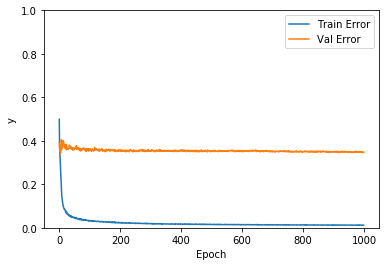

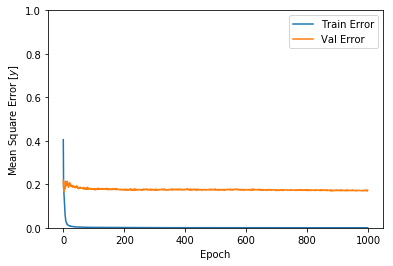

Testing set Mean Abs Error:  0.36
Testing set Mean Square Error:  0.18


In [7]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('y')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,1])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$y$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,1])
  plt.show()

plot_history(history)

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Square Error: {:5.2f}".format(mse))

In [8]:
test_predictions = model.predict(test_dataset).flatten()

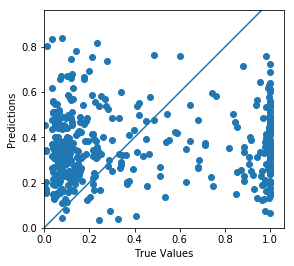

In [9]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])
plt.show()

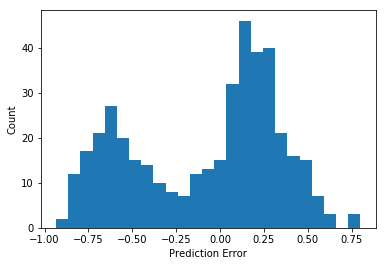

In [10]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

We can see from the error plots that there is no improvement in erorr on the validation dataset after the first few epoch.  This indicates that the model is overfitting the data.  Let's compare the neural network to the LASSO.

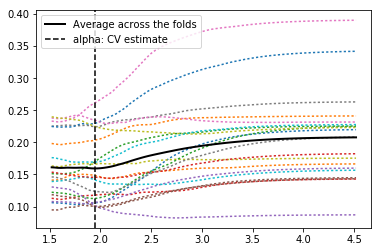

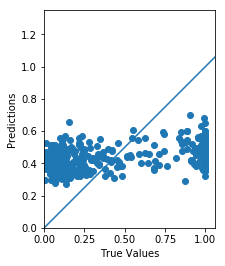

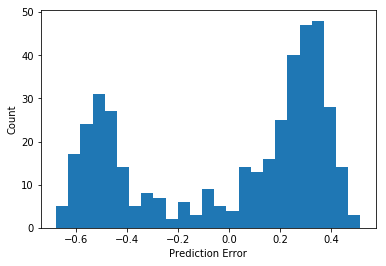

0.136368925426


In [11]:
from sklearn.linear_model import LassoCV 
from sklearn.linear_model import Lasso

model = LassoCV(cv=20).fit(test_dataset, test_labels)

# Display results
m_log_alphas = -numpy.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-numpy.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()
plt.show()

lasso = Lasso(alpha = model.alpha_)
lasso.fit(test_dataset, test_labels)
coeff_used = numpy.sum(lasso.coef_!=0)

lasso_predictions = lasso.predict(test_dataset).flatten()
plt.scatter(test_labels, lasso_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])
plt.show()

error = lasso_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

mse = numpy.mean(error*error)
print(mse)

We see that the mean square error for the lasso is lower than the neural network predictions, likely because the neural net is overfitting the training data.  The lasso is using single base pair information, while the neural network is using convolutional information.  Likely we don't have enough data yet to generalize the predictions.  See also Kim et al, Nat Biotech 2018 (https://www.nature.com/articles/nbt.4061), although it should be noted that their conclusion is that deep learning improves prediction despite the fact that it doesn't in out of sample error (Fig 2).  